In [1]:
from od import OD
from test_data import generate_test
import datetime
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import auc, fps, TimeoutException
import os
import numpy as np
import stopit
import pandas as pd

In [88]:
n = 100
p = 32

gamma = 0.05
p_frac = 0.3
p_quant = 0.3
r = 20
# out_type = 'point'

timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)

2021-06-10_11-22-03


In [89]:

def plot_data(timestamp):
    # matrix plots
    pca = PCA(2, svd_solver='full')
    pca_lst = []
    out_lst = []
    plt.figure(figsize=(3*2+1.5,2+1.5))
    for i in range(6):
        fig = plt.subplot(1,6,i+1)
        X, outs = generate_test(n,p,r, p_frac, p_quant,gamma, noise=0.1, ta=i+1)
        plt.imshow(X)
        # plt.title('noise = {}'.format(np.round(i/5, 1)) )
        for out in outs:
            fig.text(-5,out+2, 'o-', color='r')
        plt.title('D{}'.format(i+1))
        #pca plots
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca.fit_transform(X)
        pca_lst.append(X_pca)
        out_lst.append(outs)
    fname = '{}_data_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp,n,p,r,gamma,p_frac,p_quant)
    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.figure(figsize=(3*3+2,2*2.5+1))
    for i in range(6):
        fig = plt.subplot(2,3,i+1)
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca_lst[i]
        outs = out_lst[i]
        plt.plot(X_pca[:,0], X_pca[:,1], 'b.')
        plt.title('D{}'.format(i+1))

        for out in outs:
            # print(out)
            plt.plot(X_pca[out, 0], X_pca[out,1], 'rx')
    fname = '{}_data_pca_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp, n,p,r,gamma,p_frac,p_quant)

    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
def plot_data_noise(timestamp):
    # matrix plots
    pca = PCA(2, svd_solver='full')
    pca_lst = []
    out_lst = []
    plt.figure(figsize=(3*2+1.5,2+1.5))
    for i in range(6):
        fig = plt.subplot(1,6,i+1)
        X, outs = generate_test(n,p,r, p_frac, p_quant,gamma, noise=i/5, ta=1)
        plt.imshow(X)
        plt.title('noise\n={}'.format(round(i/5, 1)) )
        for out in outs:
            fig.text(-5,out+1, 'o-', color='r')

        #pca plots
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca.fit_transform(X)
        pca_lst.append(X_pca)
        out_lst.append(outs)
    fname = '{}_data_noise_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp,n,p,r,gamma,p_frac,p_quant)
    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.figure(figsize=(3*3+2,2*2.5+1))
    for i in range(6):
        fig = plt.subplot(2,3,i+1)
        fig.set_xticks([])
        fig.set_yticks([])
        X_pca = pca_lst[i]
        outs = out_lst[i]
        plt.plot(X_pca[:,0], X_pca[:,1], 'b.')
        plt.title('noise {}'.format(i))
        for out in outs:
            # print(out)
            plt.plot(X_pca[out, 0], X_pca[out,1], 'rx')
    fname = '{}_data_noise_pca_plot_n{}_p{}_r{}_g{}_pf{}_pq{}.png'.format(timestamp, n,p,r,gamma,p_frac,p_quant)

    plt.savefig('./images/'+fname, bbox_inches='tight', pad_inches=0.1)
    plt.show()

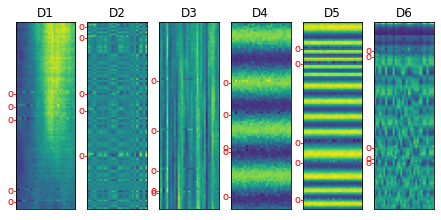

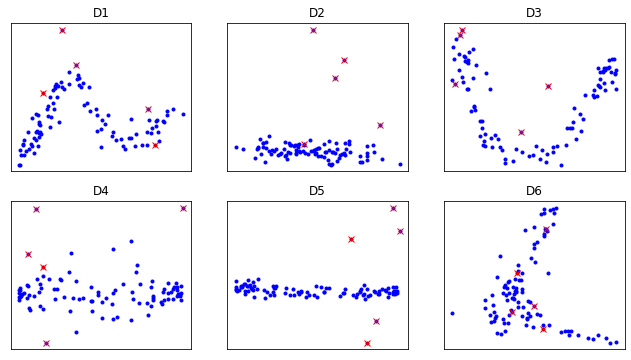

In [90]:
plot_data(timestamp)

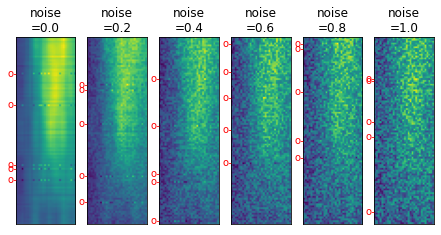

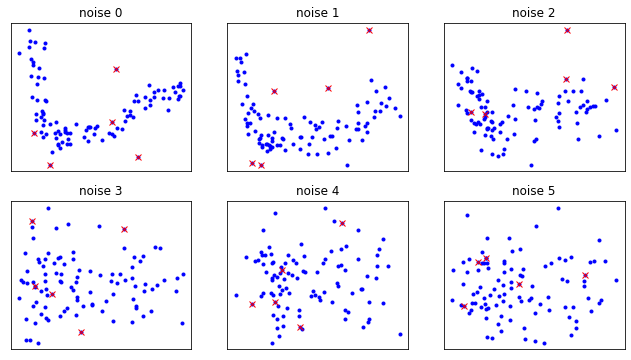

In [91]:
plot_data_noise(timestamp)

In [111]:

def contour_fp_np(n_lst, p_lst, r, noise, ta, p_quant, p_frac, n_runs, gamma,algo,algo_str, metric, timeout, timestamp):
    """
    gets data for contour plot varying
    n - number of samples
    p - number of features
    with 0.3 p frac and p_quant, using ceiling, so always at least 1 outlier
    saving the data in a text file with the time stamp given.
    """

    all_name = './results/{}_np_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, '.format('algo', 'ta', 'score', 'n', 'p')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for p_pow in p_lst:
        fp_row=[]
        auc_row=[]
        succeed = True
        for n_pow in n_lst:
            Fail = False
            t0 = time()
            fp_runs=[]
            auc_runs=[]
            n = 10**n_pow
            p = 2**p_pow

            for i in range(n_runs):

                la_err = True
                while la_err and succeed:
                    try:
                        X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                        with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                            fp, auc = test_algo(X, outs, algo, metric)
                        if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                            raise TimeoutException(timeout)
                        la_err = False
                        # print('got to end of try')

                    except np.linalg.LinAlgError as err:
                        if 'Singular matrix' in str(err):
                            la_err = True
                            print('redoing due to singular matrix err')
                        elif 'SVD did not converge':
                            la_err = True
                            print('redoing due to SVD not converging')
                        else:
                            # print(err)
                            print('some other linalg error')
                            raise(err)
                    except TimeoutException as err:
                        succeed = False
                        #want it not to bother to run another run,
                        #and not to bother trying the next n_pow up
                if succeed:
                    fp_runs.append(fp)
                    auc_runs.append(auc)
                else:
                    break
            t1 = time() - t0
            if Fail:
                Fail = False
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                print('n={}, p={}, Failed, LinAlgError'.format(n, p))
            elif not succeed:
                print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                    auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                    f.write(fp_str)
                    f.write(auc_str)
            else:
                fp_row.append(np.mean(fp_runs))
                auc_row.append(np.mean(auc_runs))
                #saving raw data to file
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'fps',n,p)
                    fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                    auc_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'auc',n,p)
                    auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
                print('n={}, p={}, runs={}, time= {}m {}s'.format(n, p, n_runs, int(t1//60),int(t1%60)))
        fps.append(fp_row)
        aucs.append(auc_row)

    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz

def plot_each_algo_for_np(n_lst, p_lst, r, gamma, noise, ta, p_quant, p_frac, n_runs,
                            algo_lst, metric, timeout, timestamp):



    t0 = time()

    for i in range(len(algo_lst)):
        algo = algo_lst[i]
        t1 = time()
        od = OD(algo)

        print('{}'.format(algo))
        fpz, aucz = contour_fp_np(n_lst, p_lst, r, noise, ta,p_quant, p_frac, n_runs, gamma,od.get_os, algo, metric, timeout, timestamp)

        t2 = time()-t1

        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(n_lst)*len(p_lst)*n_runs))
    t3 = time()-t0

    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))
    return

def test_algo(X, outs, algo, metric):
    """
    takes in algorithm 'algo', data 'X', with outlier indices 'outs'
    returns fps and auc score, defined in the list of metrics 'metric'
    algo must have input only X
    """
    outlier_scores = algo(X)
    fps = metric[1](outlier_scores, outs)
    aucs = metric[0](outlier_scores, outs)

    return fps, aucs

def get_all_data_np(timestamp):
    all_name = './results/{}_np_all.txt'.format(timestamp)

    df = pd.read_csv(all_name, skipinitialspace=True, index_col=False, header=0)
    n_runs = int(df.columns[-1])
    df['ta']=df.ta.astype('str')
    df['n']=df.n.astype('str')
    df['p']=df.p.astype('str')


    dfm = df.mean(axis=1, skipna=True, numeric_only=True)

    df['mean']=dfm

    dfr=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1 )
    dfr = dfr.pivot_table(index='algo', columns=['score', 'ta'],values=['mean'])
    dfr = dfr.round(2)
    dfr = dfr.astype(type('s'))
#     print(dfr)
    return df, dfr


def get_contour_plot(ts,ta, plot_type, algo_type, score, df, n_runs):
    """
    takes time stamp, fimds file, loads data, produces contour plots for each algotype.
    """
    from matplotlib import ticker
    from numpy import ma

    if plot_type == 'np':
        nv = 24
        rx = 6
        ry = 4
        xl = 'samples'
        yl = 'features'

    elif plot_type == 'pfq':
        nv = 36
        rx = 6
        ry = 6
        xl = 'p_frac'
        yl = 'p_quant'

    else:
        raise 'unknown plot type error'

    algo_type_dict={'reg':['VAR', 'FRO', 'FRL', 'FRR'], 'dens':['OCSVM', 'GMM', 'DBSCAN', 'IF'],
                    'dl':['AE', 'VAE', 'LSTM', 'GRU'], 'mat':['OP', 'GOP']}
    print(df.info())
    print(ta, type(ta))
    print(score)
    df = df[df['ta']==str(ta)]

    df=df[df['score']==score]
    w = len(algo_type_dict[algo_type])
    v=1
    fig_size_x = w*5
    fig_size_y = 5
    plt.figure(figsize=(fig_size_x, fig_size_y))
    for i in range(w):
        algo = algo_type_dict[algo_type][i]
        dfa = df[df['algo'] ==algo]
        print(dfa.info())
        plt.subplot(v,w, (w*0 + i)+1)
        if i == 0:
            plt.ylabel(yl)
        label = 'ta_{}'.format(ta)
        plt.title('{}'.format(algo))

        if plot_type == 'pfq':
            pqs = dfa['pq'].to_numpy().reshape(rx, ry)
            pfs = dfa['pf'].to_numpy().reshape(rx, ry)
            avgs = dfa['mean'].to_numpy().reshape(rx, ry)
            plt.contourf(pqs, pfs, avgs) #,np.arange(0,1+1e-8,0.05),vmin=0, vmax=1) #

        elif plot_type == 'np':
            ns = dfa['n'].to_numpy().reshape(rx, ry)
            ps = dfa['p'].to_numpy().reshape(rx, ry)
            avgs = dfa['mean'].to_numpy().reshape(rx, ry)
#             print(avgs)
            plt.xscale('log')
            plt.yscale('log')
            print(ns.shape, ps.shape, avgs.shape)
            plt.contourf(ns, ps, avgs) #,levels=np.arange(0,1+1e-8,0.05)) #,vmin=0, vmax=1)

        else:
            raise 'plot type unknown'
        plt.xlabel(xl)
        if i == w-1:
            plt.colorbar()
    fname = './images/{}_{}_{}_ta{}.eps'.format(ts, plot_type, algo_type, ta)

    plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
def run_np_experiment_1(timestamp):

    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']

    r = 20
    p_frac = 0.3
    p_quant = 0.3
    n_runs = 10
    gamma = 0.05
    timeout = 120
    noise=.1
    ta_lst = [1,2,3,4,5,6]
    p_lst = [1, 2, 3, 4, 5, 6]
    n_lst = [1, 2, 3, 4]

    ## for testing - comment out to run full experiment. may take a while..
    ta_lst = [1,2]
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM']
    n_runs=2
    
    ## end of testing section

    metric_lst = [auc, fps]
    for ta in ta_lst:
        plot_each_algo_for_np(n_lst, p_lst, r, gamma, noise, ta, p_quant, p_frac,n_runs,
                                    algo_lst, metric_lst, timeout, timestamp)


    return

VAR
n=10, p=2, runs=2, time= 0m 0s
n=100, p=2, runs=2, time= 0m 0s
n=1000, p=2, runs=2, time= 0m 0s
n=10000, p=2, runs=2, time= 0m 5s
n=10, p=4, runs=2, time= 0m 0s
n=100, p=4, runs=2, time= 0m 0s
n=1000, p=4, runs=2, time= 0m 0s
n=10000, p=4, runs=2, time= 0m 2s
redoing due to singular matrix err
n=10, p=8, runs=2, time= 0m 0s
n=100, p=8, runs=2, time= 0m 0s
n=1000, p=8, runs=2, time= 0m 0s
n=10000, p=8, runs=2, time= 0m 0s
n=10, p=16, runs=2, time= 0m 0s
n=100, p=16, runs=2, time= 0m 0s
n=1000, p=16, runs=2, time= 0m 0s
n=10000, p=16, runs=2, time= 0m 0s
n=10, p=32, runs=2, time= 0m 0s
n=100, p=32, runs=2, time= 0m 0s
n=1000, p=32, runs=2, time= 0m 0s
n=10000, p=32, runs=2, time= 0m 0s
n=10, p=64, runs=2, time= 0m 0s
n=100, p=64, runs=2, time= 0m 0s
n=1000, p=64, runs=2, time= 0m 0s
n=10000, p=64, runs=2, time= 0m 2s
Algorithm VAR with ta 1 took 0m and 12s to run 48 times
FRO
n=10, p=2, runs=2, time= 0m 0s
n=100, p=2, runs=2, time= 0m 0s
n=1000, p=2, runs=2, time= 0m 0s
n=10000, p=2,

n=10000, p=16, runs=2, time= 0m 8s
n=10, p=32, runs=2, time= 0m 0s
n=100, p=32, runs=2, time= 0m 0s
n=1000, p=32, runs=2, time= 0m 0s
n=10000, p=32, runs=2, time= 0m 13s
n=10, p=64, runs=2, time= 0m 0s
n=100, p=64, runs=2, time= 0m 0s
n=1000, p=64, runs=2, time= 0m 0s
n=10000, p=64, runs=2, time= 0m 23s
Algorithm OCSVM with ta 2 took 1m and 6s to run 48 times
Took 2m 5s to run all algorithms
       mean                  
score   auc         fps      
ta        1     2     1     2
algo                         
FRL    0.66  0.75  0.87  0.82
FRO    0.92  0.96  0.35  0.18
FRR    0.93  0.94  0.33  0.24
OCSVM  0.87  0.92  0.63   0.4
VAR    0.83  0.67  0.53  0.85
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 8 columns):
algo     960 non-null object
ta       960 non-null object
score    960 non-null object
n        960 non-null object
p        960 non-null object
1        960 non-null float64
2        960 non-null float64
mean     960 non-null floa

ValueError: cannot reshape array of size 48 into shape (6,4)

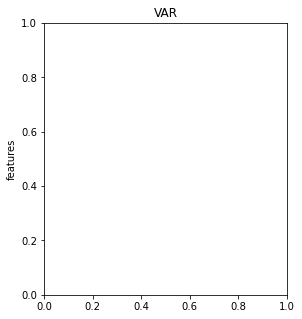

In [113]:
run_np_experiment_1(timestamp)

df, dfr = get_all_data_np(timestamp)
print(dfr)
ta=1
n_runs=2
for algo_type in ['reg']: #, 'dens', 'dl', 'mat']:  ## comment the rest of this back in for full experiment
    get_contour_plot(timestamp,ta, 'np', algo_type, 'auc', df, n_runs)

In [ ]:
def contour_auc_pfq(pf_lst, pq_lst, r, noise, ta, n, p, n_runs, gamma,algo, algo_str,metric, timeout, timestamp):
    """
    makes the data for the contour plot while varying p frac and p quant
    using ceiling, so always at least 1 outlier
    saves information from each run in textfile with timestamp given.
    """

    all_name = './results/{}_pfq_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, '.format('algo', 'ta', 'score', 'pf', 'pq')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for p_frac in pf_lst:
        fp_row=[]
        auc_row=[]
        succeed = True
        for p_quant in pq_lst:
            Fail = False
            t0 = time()
            fp_runs=[]
            auc_runs=[]

            for i in range(n_runs):
                la_err = True
                while la_err and succeed:
                    try:
                        X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                        with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                            fp, auc = test_algo(X, outs, algo, metric)
                        if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                            raise TimeoutException(timeout)
                        la_err = False

                    except np.linalg.LinAlgError as err:
                        if 'Singular matrix' in str(err):
                            la_err = True
                            print('redoing due to singular matrix err')
                        else:
                            # shouldn't happen, so throw an error please.
                            print('some other linalg error')
                            raise(err)
                    except TimeoutException as err:
                        # print('timeout after {}s'.format(timeout))
                        succeed = False
                        #want it not to bother to run another run,
                        #and not to bother trying the next n_pow up

                if succeed:
                    fp_runs.append(fp)
                    auc_runs.append(auc)
                else:
                    break
            t1 = time() - t0
            if Fail:
                Fail = False
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                print('n={}, p={}, Failed, LinAlgError'.format(n, p))
            elif not succeed:
                print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                    fp_str = fp_str+join(['%0.3f, '])*n_runs%[n_runs*np.nan]+'\n'
                    auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                    auc_str = auc_str+join(['%0.3f, '])*n_runs%[n_runs*np.nan]+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
            else:
                # print(runs)
                fp_row.append(np.mean(fp_runs))
                auc_row.append(np.mean(auc_runs))
                #saving raw data to file
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'fps',p_frac,p_quant)
                    fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                    auc_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'auc',p_frac,p_quant)
                    auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
                print('p_frac={}, quant={}, runs={}, time= {}m {}s'.format(round(p_frac,3), round(p_quant,3), n_runs, int(t1//60),int(t1%60)))
        fps.append(fp_row)
        aucs.append(auc_row)

    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz

def plot_each_algo_for_pfq(pf_lst, pq_lst, r, gamma, noise, ta, n, p, n_runs,
                            algo_lst, metric,  timeout, timestamp):
    t0 = time()
    for i in range(len(algo_lst)):
        t1 = time()
        algo = algo_lst[i]
        od = OD(algo)
        print('{}'.format(algo))
        fpz, aucz = contour_auc_pfq(pf_lst, pq_lst, r, noise, ta, n, p, n_runs, gamma,od.get_os,algo, metric, timeout, timestamp)
        t2 = time()-t1
        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(pf_lst)*len(pq_lst)*n_runs))
    t3 = time()-t0

    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))

    return


def get_all_data_pfq(timestamp):
    all_name = './results/{}_pfq_all.txt'.format(timestamp)

    df = pd.read_csv(all_name, skipinitialspace=True, index_col=False, header=0)
    n_runs = int(df.columns[-1])
    df['ta']=df.ta.astype('str')
    df['pf']=df.n.astype('str')
    df['pq']=df.p.astype('str')


    dfm = df.mean(axis=1, skipna=True, numeric_only=True)

    df['mean']=dfm

    dfr=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1 )
    dfr = dfr.pivot_table(index='algo', columns=['score', 'ta'],values=['mean'])
    dfr = dfr.round(2)
    dfr = dfr.astype(type('s'))
#     print(dfr)
    return df, dfr

def run_pfq_experiment_2(timestamp):
    """
    takes time stamp, runs experiment, prints results table, produces contour plots.
    """

    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']

    r = 20
    n_runs = 10
    gamma = 0.05
    timeout = 900
    noise=.1

    pf_lst = np.arange(0.0,1.01,0.2)
    pq_lst = np.arange(0.0,1.01,0.2)
    n = 1000
    p = 32
    metric_lst = [auc, fps]
    ta_lst = [1,2,3,4,5,6]
    
    ## for testing - commend this section out to run full experiment
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM']
    ta_lst = [1,2]
    n_runs=2
    ## end of testing section
    
    for ta in ta_lst:
        plot_each_algo_for_pfq(pf_lst, pq_lst, r, gamma, noise, ta, n, p, n_runs,
                                    algo_lst, metric_lst, timeout, timestamp)

    df, dfr = get_all_data_pfq(timestamp)
    print(dfr)
    ta = 1
    plot_type = 'pfq'
    algo_type = 'reg'
    score = 'auc'
    for algo_type in ['reg']: #, 'dens', 'dl', 'mat']: #comment rest of this back in to get plots for all experiments
        get_contour_plot(timestamp,ta, plot_type, algo_type, score, df, n_runs)
    return



In [ ]:
run_pfq_experiment_2(timestamp)